In [85]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [86]:
import numpy as np
import pandas as pd

In [87]:
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Reflect Tables into SQLAlchemy ORM

In [88]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import MetaData, Table
# import pandas as pd

In [89]:
engine = create_engine("sqlite:///hawaii.sqlite")
connection = engine.connect()

In [90]:
meta = MetaData()
meta.reflect(bind=engine)

In [91]:
# reflect an existing database into a new model
meta.reflect(engine, only=['measurement', 'station'])
Base = automap_base(metadata=meta)
Base.prepare()

measurement, station = Base.classes.measurement, Base.classes.station

# reflect the tables
tbl_measurement = Table('measurement', meta, autoload=True, autoload_with=engine)
tbl_station = Table('station', meta, autoload=True, autoload_with=engine)

In [92]:
tbl_measurement

Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None)

In [93]:
# Save references to each table
measurement, station = Base.classes.measurement, Base.classes.station

In [94]:
# Create our session (link) from Python to the DB


# Exploratory Climate Analysis

In [95]:
# from sqlalchemy.sql import select
from sqlalchemy.sql import text

Date from 1 year ago from latest date in database: 
['2016-08-23']
            precipitation
date                     
2016-08-23           2.71
2016-08-24           9.33
2016-08-25           0.54
2016-08-26           0.10
2016-08-27           0.32
2016-08-28           3.10
2016-08-29           1.46
2016-08-30           0.07
2016-08-31           3.18
2016-09-01           0.03
2016-09-02           0.25
2016-09-03           1.27
2016-09-04           1.38
2016-09-05           0.34
2016-09-06           1.23
2016-09-07           2.00
2016-09-08           0.46
2016-09-09           1.07
2016-09-10           1.40
2016-09-11           1.25
2016-09-12           1.54
2016-09-13           2.71
2016-09-14          14.28
2016-09-15           4.96
2016-09-16           0.82
2016-09-17           0.68
2016-09-18           0.53
2016-09-19           0.32
2016-09-20           1.03
2016-09-21           1.17
...                   ...
2017-07-25           0.61
2017-07-26           0.50
2017-07-27           0.

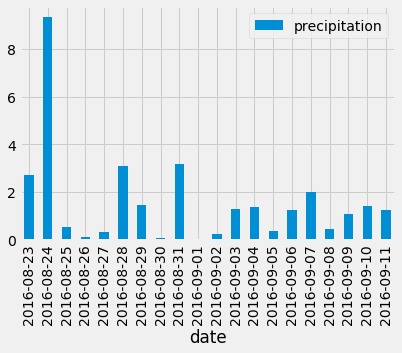

In [97]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
s = text ("Select * from measurement where date >= date('now','start of year', '-1 year')")
result = connection.execute(s).fetchall()
for row in result:
    print(row)

# Calculate the date 1 year ago from the last data point in the database
s = text ("Select date((select max(date) from measurement), '-1 year') As Date")
result = connection.execute(s).fetchall()
for row in result:
    print('Date from 1 year ago from latest date in database: ')
    print(row.values())


# Perform a query to retrieve the data and precipitation scores
s = text ("Select date, prcp from measurement where date >= date((select max(date) from measurement), '-1 year')")
result = connection.execute(s).fetchall()
"""for row in result:
    print(row)"""

# Save the query results as a Pandas DataFrame and set the index to the date column
df_date_prcp = pd.DataFrame(result)
df_date_prcp.columns = result[0].keys()
df_date_prcp = df_date_prcp.groupby('date').sum().reset_index()
df_date_prcp  = df_date_prcp.set_index(df_date_prcp.date) 
df_date_prcp = df_date_prcp.drop('date', axis=1)
# # Sort the dataframe by date
# df_date_prcp = df_date_prcp.sort_values('date', ascending=0)
df_date_prcp = df_date_prcp.rename(columns={'prcp':'precipitation'})
print(df_date_prcp)
# Use Pandas Plotting with Matplotlib to plot the data
# df_date_prcp.head(20).plot(kind='bar', xlabel = 'Date', ylabel ='inches')
df_date_prcp.head(20).plot(kind='bar',)

In [98]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_date_prcp.describe()

,precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [106]:
# Design a query to show how many stations are available in this dataset?
s = text ("Select count(distinct station) from measurement")
result = connection.execute(s).fetchall()
for row in result:
    print('Below is the count of stations: ')
    print("Number of Station available : ",row.values()[0])
    

Below is the count of stations: 
Number of Station available :  9


In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
s = text ("Select name, count(1) As Count from measurement m inner join station s on m.station = s.station group by s.name order by count(1) desc")
result = connection.execute(s).fetchall()
print('Below are the Station and their frequency: ')
for row in result:
    print(row)

Below are the Station and their frequency: 
('WAIHEE 837.5, HI US', 2772)
('WAIKIKI 717.2, HI US', 2724)
('KANEOHE 838.1, HI US', 2709)
('WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('MANOA LYON ARBO 785.2, HI US', 2612)
('KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('HONOLULU OBSERVATORY 702.2, HI US', 1979)
('PEARL CITY, HI US', 1372)
('UPPER WAHIAWA 874.3, HI US', 511)


In [108]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
s = text ("Select min(tobs) AS LowestTemp, max(tobs) As MaxTmp, avg(tobs) As AvgTemp from measurement where station = 'USC00519281'")
result = connection.execute(s).fetchall()
for row in result:
    print('Below is the Lowest, highest and Average Temperature of station')
    print(row)

Below is the Lowest, highest and Average Temperature of station
(54.0, 85.0, 71.66378066378067)


In [119]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
s = text ("Select station, tobs, date, 1 AS frequency from measurement")
result = connection.execute(s).fetchall()
station_data = pd.DataFrame(result)
station_data.columns = result[0].keys()

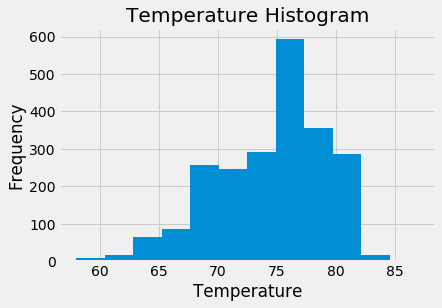

In [120]:
station_data_freq = station_data[['station', 'frequency']].groupby('station').sum().reset_index()

# Get Station with Max Freqency
station_maxFreq = station_data_freq[station_data_freq['frequency'] == station_data_freq['frequency'].max()]['station'].values[0]

# Get all data for station having max freqency
station_data_max_frequency = station_data[station_data['station']==station_maxFreq]

# We need to get data for last 12 months from most recent date, so convert date column value to date format
station_data['date'] = pd.to_datetime(station_data['date'], errors = 'ignore')
# station_data['date'] = station_data['date'].dt.date

from pandas.tseries.offsets import DateOffset
# Get max date
dt_max = station_data.date.max()
# Get 12 months old date
dt_prev12Months = dt_max - DateOffset(months=12)

# Get station data for 12 latest months
station_data = station_data[station_data.date>=dt_prev12Months]
# print(station_data)
station_data = station_data.drop('station', axis=1)

# print(station_data)


n_bins = 12
plt.hist(station_data['tobs'], n_bins,histtype ='bar') 
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Temperature Histogram")

In [50]:
from sqlalchemy.orm import sessionmaker

Session = sessionmaker(bind=engine)
session = Session()

## Bonus Challenge Assignment

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [77]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
print(calc_temps('2012-02-28', '2012-03-05'))

# for your trip using the previous year's data for those same dates.
ses_results = session.query(measurement.id,measurement.station,measurement.date,measurement.prcp,measurement.tobs).\
        filter(measurement.date >= '2012-02-28').filter(measurement.date <= '2012-03-05').all()
station_data_freq_daterange = pd.DataFrame(ses_results)
station_data_freq_daterange['frequency'] = 1

[(62.0, 69.57142857142857, 74.0)]


In [80]:
station_data_freq_daterange.head()

,id,station,date,prcp,tobs,frequency
0,730,USC00519397,2012-02-28,0.00,73.0,1
1,731,USC00519397,2012-02-29,0.00,74.0,1
2,732,USC00519397,2012-03-01,0.06,73.0,1
3,733,USC00519397,2012-03-02,0.00,67.0,1
4,734,USC00519397,2012-03-03,0.03,71.0,1


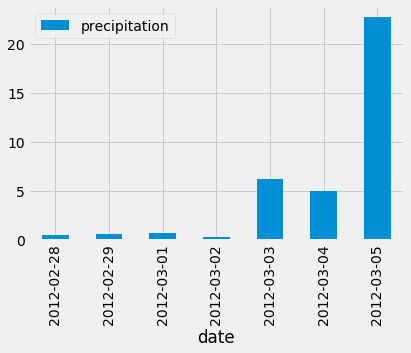

In [79]:
station_data_freq_range = station_data_freq_daterange[['date','prcp']]
station_data_freq_range = station_data_freq_range.groupby('date').sum().reset_index()
station_data_freq_range  = station_data_freq_range.set_index(station_data_freq_range.date) 
station_data_freq_range = station_data_freq_range.drop('date', axis=1)
# # Sort the dataframe by date
# df_date_prcp = df_date_prcp.sort_values('date', ascending=0)
station_data_freq_range = station_data_freq_range.rename(columns={'prcp':'precipitation'})
# Use Pandas Plotting with Matplotlib to plot the data
# df_date_prcp.head(20).plot(kind='bar', xlabel = 'Date', ylabel ='inches')
station_data_freq_range.head(20).plot(kind='bar')

In [82]:
# Use Pandas to calcualte the summary statistics for the precipitation data
station_data_freq_range.describe()

,precipitation
count,7.000000
mean,5.131429
std,8.128117
min,0.260000
25%,0.540000
50%,0.700000
75%,5.575000
max,22.730000


In [ ]:
# Design a query to show how many stations are available in this dataset?
s = text ("Select count(distinct station) from measurement")
result = connection.execute(s).fetchall()
for row in result:
    print('Below is the count of stations: ')
    print(row.values())

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [121]:
dic = {"ABC":"abc","BCD":"bcd"}

In [127]:
list(dic.values())[0]

'abc'